In [ ]:
%run /media/data/home/s370876/evaluation/wue_lab_eval.py --write_samples

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
from pandas.core.common import flatten
from glob import glob
import seaborn as sns
import pandas as pd
import imp
import pickle
from random import randrange

/media/data/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/data/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/data/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/media/data/anaconda3/envs/tf114/lib/python3.7/site-

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

/media/data/home/s370876/wue_lab_eval_output_dir_18k/0099_cFOS_sample3.npy


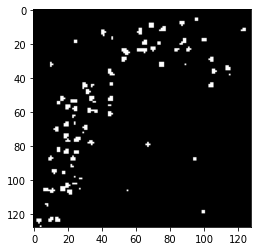

In [3]:
cf = imp.load_source('cf', '/media/data/home/s370876/evaluation/wue_lab_eval_config.py')
path = cf.out_dir

ix = randrange(cf.sample_size)
img_path = os.path.join(path, os.listdir(path)[ix])
print(img_path)
img = np.load(img_path)

f = plt.figure(figsize=(8,4))
plt.imshow(img[0,0], cmap='gray')
plt.show()

## Summary Plots

In [13]:
#set seed for reproducibility
np.random.seed(0)

In [5]:
def generate_samples(cf, batch_size=8):

    """Assembles a batch of the first image for each specified patient.
    A tuple holding the batched image of shape (b, 1, 128, 128) and the batched
    segmentations of shape (b, 4, 128, 128).
    """
    img, seg, ids, samples, avg_masks = [], [], [], [], []
    patient_dirs = glob(os.path.join(cf.out_dir, 'images', '*'))
    img_ixs = list(np.random.choice(patient_dirs, batch_size, replace=False))

    for i in range(batch_size):
        # get the first image for the patient
        img_path = img_ixs[i]
        pth_split = img_path.rsplit('/', 1)[-1][:-4]
        ids.append(pth_split)

        image = np.load(img_path)
        #image = image[np.newaxis, np.newaxis, ...]
        img.append(image)

        # get the corresponding ground truth label
        gt_base_path = img_path.replace('images', 'gt')
        # Für alle 4 Expertenmasken zu bestimmtem Bild:
        labels = []
        for l in range(cf.num_graders):
            gt_path = gt_base_path.replace('.npy', '_l{}.npy'.format(l))
            label = np.load(gt_path)
            labels.append(label)
        labels = np.concatenate(labels, axis=1)
        seg.append(labels)
        
        # Samples
        sample_base_path = img_path.replace('images/', '')
        sample_list = []
        for i in range(cf.num_samples):
            new_path = sample_base_path.replace('.npy', '_sample{}.npy'.format(i))
            sample = np.load(new_path)
            sample_list.append(sample)
        array = np.concatenate(sample_list, axis=1)
        avg_mask = np.sum(array, axis = 1)
        avg_masks.append(avg_mask)
        samples.append(array)
    
    # Concat and rearrange np arrays for BHWC format
    img_batch = np.concatenate(img, axis=0)
    img_batch = np.transpose(img_batch, (0, 2, 3, 1))
    seg_batch = np.concatenate(seg, axis=0)
    seg_batch = np.transpose(seg_batch, (0, 2, 3, 1))
    sample_batch = np.concatenate(samples, axis=0)
    sample_batch = np.transpose(sample_batch, (0, 2, 3, 1))
    avg_mask_batch = np.concatenate(avg_masks, axis=0)
   # avg_mask_batch = np.transpose(avg_mask_batch, (0, 2, 3, 1))

    batch = {'data': np.array(img_batch).astype('float32'), 'seg': np.array(seg_batch).astype('uint8'),
             'sample': np.array(sample_batch).astype('uint8'), 'avg_masks': np.array(avg_mask_batch).astype('uint8'),
             'id': ids}

    return batch

In [6]:
batch = generate_samples(cf)

In [7]:
def to_rgb(arr, cmap={0: (0, 0, 0), 1: (255, 255, 255)}):
    """
    Transform an integer-labeled segmentation map using an rgb color-map.
    :param arr: img_arr w/o a color-channel
    :param cmap: dictionary mapping from integer class labels to rgb values
    :return:
    """
    new_arr = np.zeros(shape=(arr.shape)+(3, ))
    for c in cmap.keys():
        ixs = np.where(arr == c)
        new_arr[ixs] = [cmap[c][i] / 255. for i in range(3)]
    return new_arr

def make_summary_plot(img, seg, samples, avg_masks, fs=6):
  """
  Make a grid plot of a batch of images, set of ground truth segmentations and
  corresponding reconstructions and samples. Each example is displayed in a 
  column of the plot.
  :img: Batch of images, array of shape (b, h, w, 1).
  :seg: Batch of segmentations, array of shape  (b, h, w, num_graders).
  :samples: Batch of samples, array of shape (b, h, w, num_classes,
   num_samples).
  :fs: Font size, integer.
  """
  num_samples = samples.shape[-1]
  num_graders = seg.shape[-1]
  bs = img.shape[0]
  num_rows = 1 + num_graders + 1 + num_samples

  f = plt.figure(figsize=(bs * fs, num_rows * fs))
  outer = gridspec.GridSpec(6, 1, wspace=0.1, hspace=0.1,
                            height_ratios=[1, num_graders, 1, num_samples, 1, 1])

  img_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[0], wspace=0.0, hspace=0.0)
  grader_spec = gridspec.GridSpecFromSubplotSpec(
      num_graders, bs, subplot_spec=outer[1], wspace=0.0, hspace=0.02)
  avg_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[2], wspace=0.0, hspace=0.0)
  sample_spec = gridspec.GridSpecFromSubplotSpec(
      num_samples, bs, subplot_spec=outer[3], wspace=0.0, hspace=0.02)
  grader_std_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[4], wspace=0.0, hspace=0.0)
  sample_std_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[5], wspace=0.0, hspace=0.0)
  for j in range(bs):
      # image
      ax = plt.subplot(img_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(np.concatenate([img[j] for _ in range(3)], axis=-1))
      if j == 0:
        ax.annotate('Mikroskopaufnahmen', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        
      # ground-truth
      for i in range(num_graders):
        ax = plt.subplot(grader_spec[i, j])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(to_rgb(seg[j, ..., i]))
        if j == 0 and i == 1:
          ax.annotate('Experten', (-0.2, 0.5), xycoords='axes fraction',
                      va='center', rotation=90).set_fontsize(25)
      # avg mask
      ax = plt.subplot(avg_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(avg_masks[j], cmap='gray')
      if j == 0:
        ax.annotate('Durchschnittsmaske', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
      # samples
      if num_samples % 2 != 0:
        xy = (-0.2, 0.5)
      else:
        xy = (-0.2, 1.0)
      for i in range(num_samples):
        ax = plt.subplot(sample_spec[i, j])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(samples[j, ..., i], cmap='gray')
        if j == 0 and i == num_samples // 2:
          ax.annotate('Samples', xy, xycoords='axes fraction',
                       va='center', rotation=90).set_fontsize(25)
        
      # grader standard deviation
      ax = plt.subplot(grader_std_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      std = np.std(seg[j], axis=-1)
      plt.imshow(std, cmap=plt.get_cmap('jet'))
      if j == 0:
        ax.annotate('Experten', (-0.4, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        ax.annotate('Std. Abw.', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)

      # sample standard deviation
      ax = plt.subplot(sample_std_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #samples_argmax = np.argmax(samples[j], axis=-2)
      std = np.std(samples[j], axis=-1)
      plt.imshow(std, cmap=plt.get_cmap('jet'))
      if j == 0:
        ax.annotate('Samples', (-0.4, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        ax.annotate('Std. Abw.', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        
      plt.savefig(os.path.join(cf.out_dir, 'plots/summary_samples.png'))

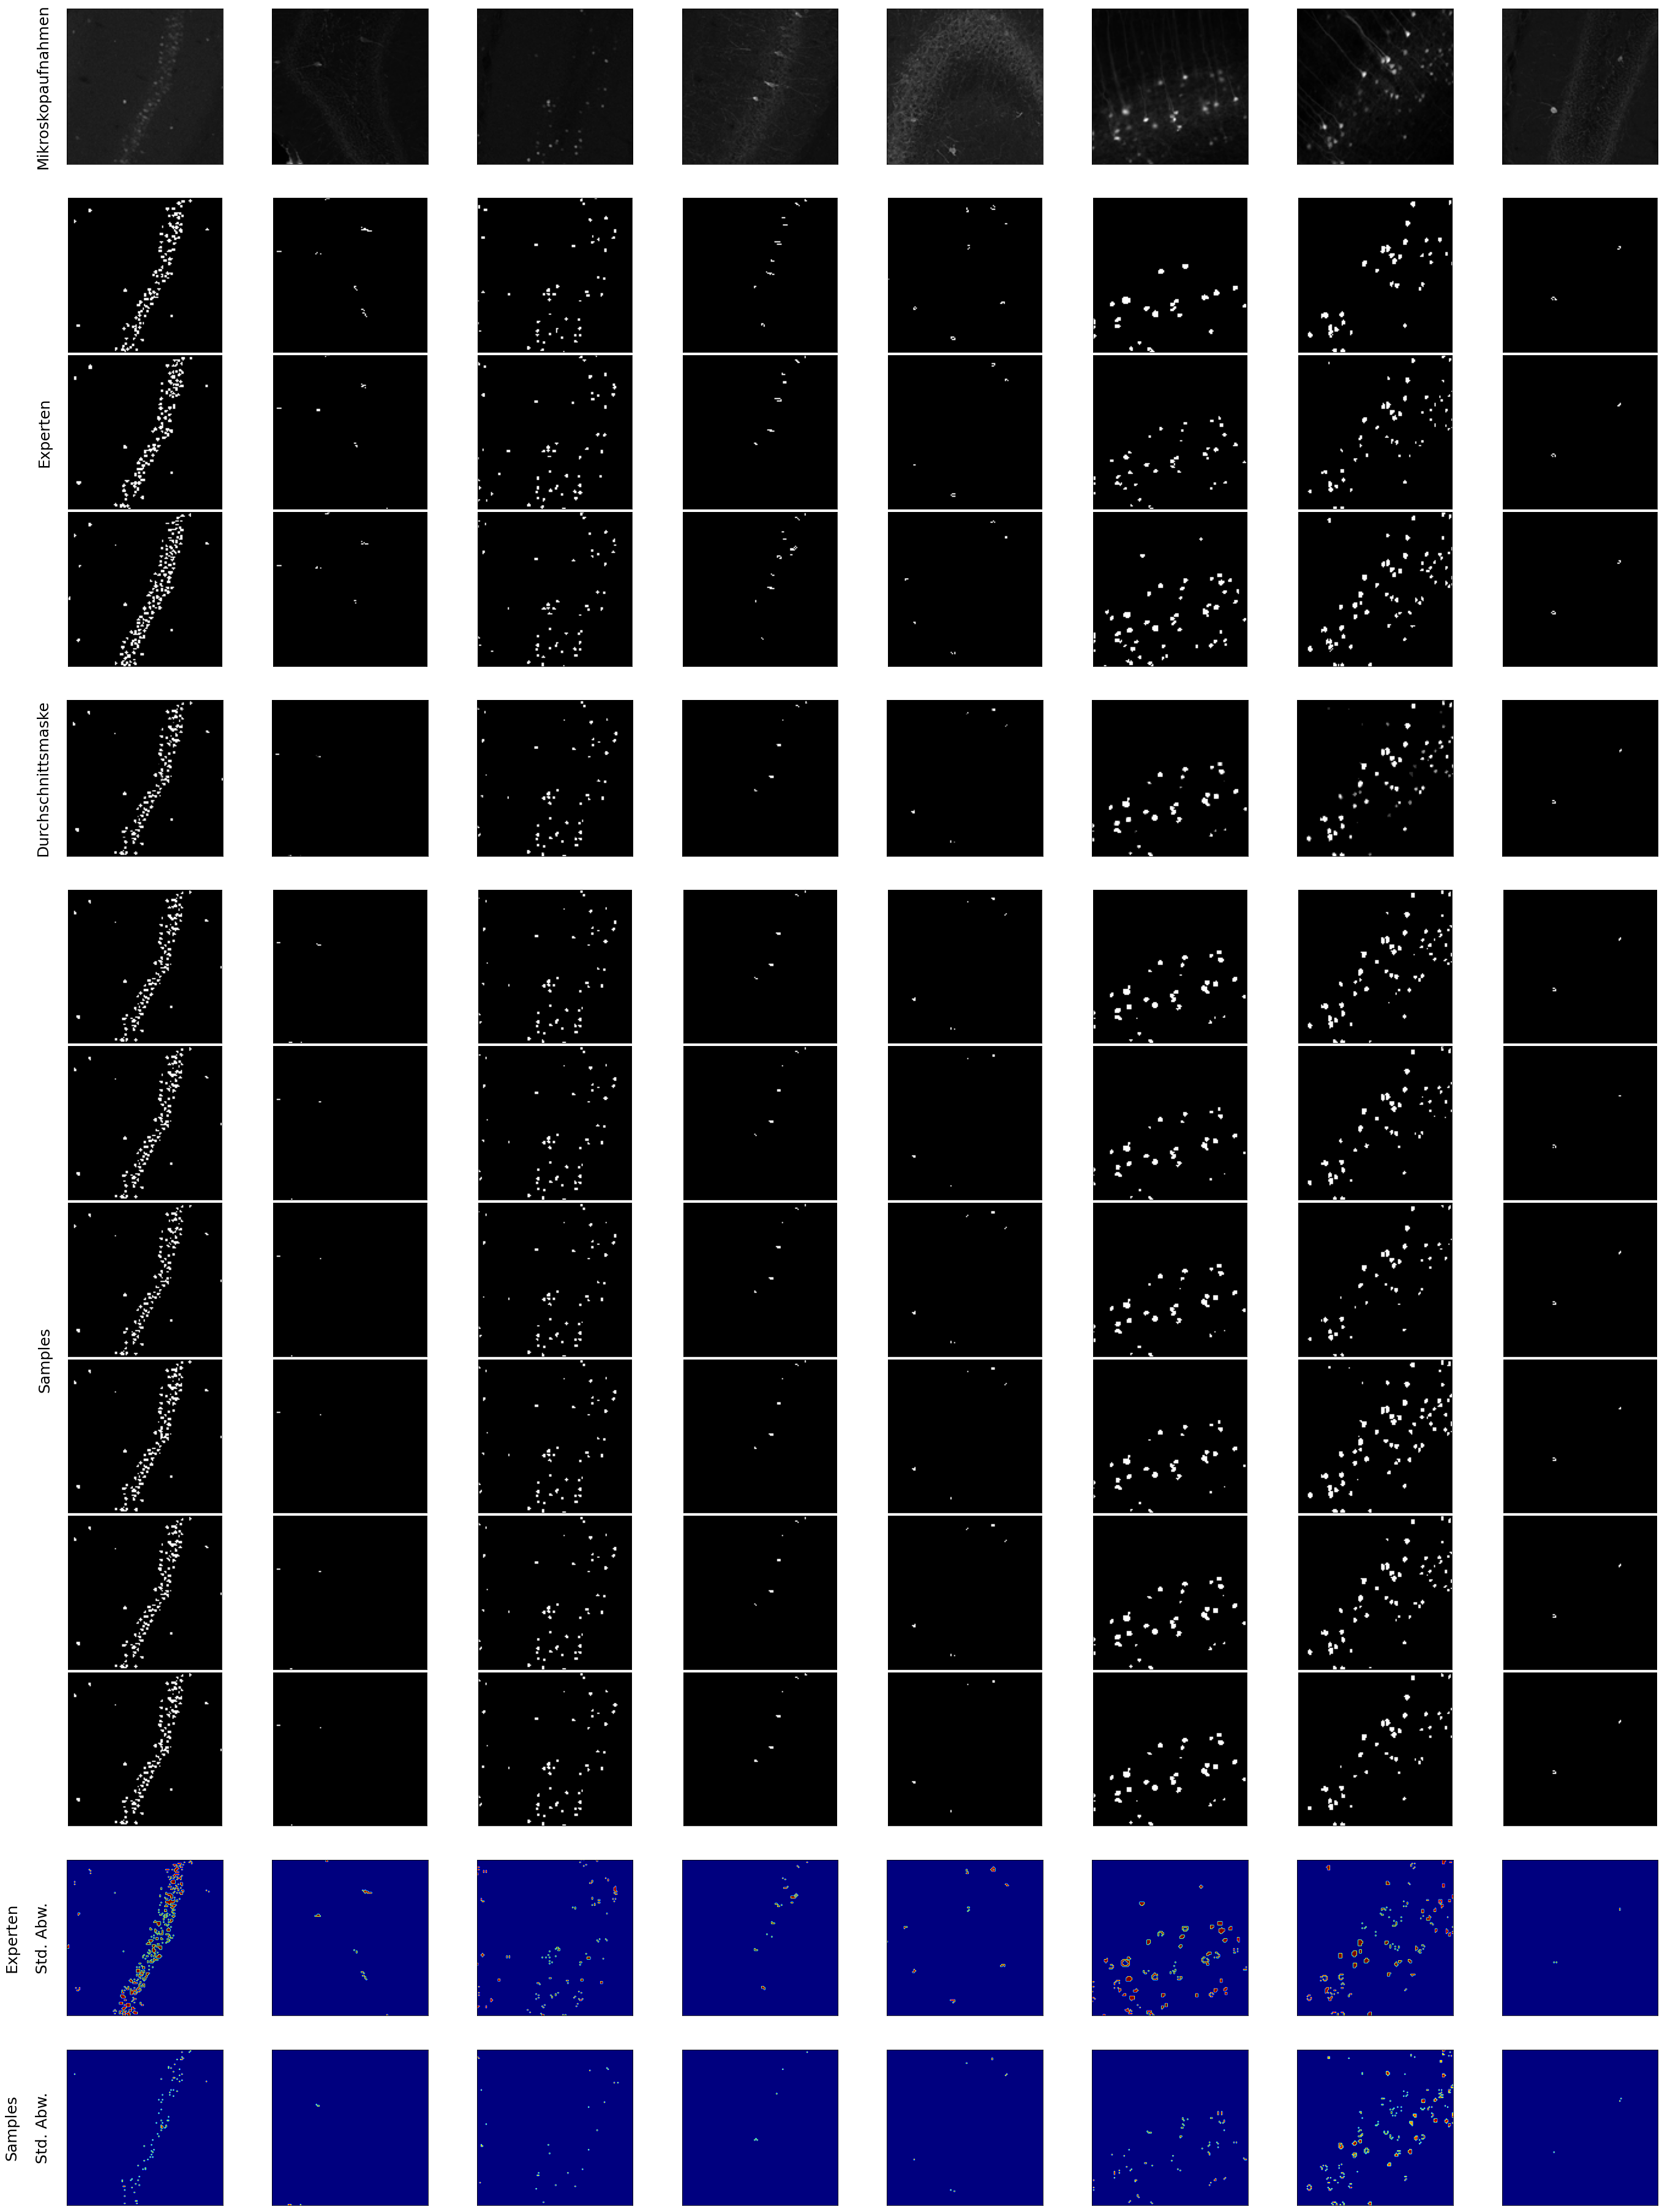

In [368]:
make_summary_plot(batch['data'], batch['seg'], batch['sample'], batch['avg_masks'], fs=6)

## Experten mit Samples

In [8]:
def generate_ds_samples(cf, batch_size=8):

    """Assembles a batch of the first image for each specified patient.
    A tuple holding the batched image of shape (b, 1, 128, 128) and the batched
    segmentations of shape (b, 4, 128, 128).
    """
    img, seg, ids, samples, avg_masks = [], [], [], [], []
    patient_dirs = glob(os.path.join(cf.out_dir, 'images', '*'))
    
    # Select one image per subdataset
    parvs = [s for s in patient_dirs if 'Parv' in s]
    opns = [s for s in patient_dirs if 'OPN3' in s]
    gfps = [s for s in patient_dirs if 'GFP' in s]
    cfoss = [s for s in patient_dirs if 'cFOS' in s]
    
    parv = list(np.random.choice(parvs, 1, replace=False))
    opn = list(np.random.choice(opns, 1, replace=False))
    gfp = list(np.random.choice(gfps, 1, replace=False))
    cfos = list(np.random.choice(cfoss, 1, replace=False))
    
    img_ixs = parv + opn + gfp + cfos

    for i in range(4):
        # get the first image for the patient
        img_path = img_ixs[i]
        pth_split = img_path.rsplit('/', 1)[-1][:-4]
        ids.append(pth_split)

        image = np.load(img_path)
        #image = image[np.newaxis, np.newaxis, ...]
        img.append(image)

        # get the corresponding ground truth label
        gt_base_path = img_path.replace('images', 'gt')
        # Für alle 4 Expertenmasken zu bestimmtem Bild:
        labels = []
        for l in range(cf.num_graders):
            gt_path = gt_base_path.replace('.npy', '_l{}.npy'.format(l))
            label = np.load(gt_path)
            labels.append(label)
        labels = np.concatenate(labels, axis=1)
        seg.append(labels)
        
        # Samples
        sample_base_path = img_path.replace('images/', '')
        sample_list = []
        for i in range(cf.num_graders):
            new_path = sample_base_path.replace('.npy', '_sample{}.npy'.format(i))
            sample = np.load(new_path)
            sample_list.append(sample)
        array = np.concatenate(sample_list, axis=1)
        avg_mask = np.sum(array, axis = 1)
        avg_masks.append(avg_mask)
        samples.append(array)
    
    # Concat and rearrange np arrays for BHWC format
    img_batch = np.concatenate(img, axis=0)
    img_batch = np.transpose(img_batch, (0, 2, 3, 1))
    seg_batch = np.concatenate(seg, axis=0)
    seg_batch = np.transpose(seg_batch, (0, 2, 3, 1))
    sample_batch = np.concatenate(samples, axis=0)
    sample_batch = np.transpose(sample_batch, (0, 2, 3, 1))
    avg_mask_batch = np.concatenate(avg_masks, axis=0)
   # avg_mask_batch = np.transpose(avg_mask_batch, (0, 2, 3, 1))

    batch = {'data': np.array(img_batch).astype('float32'), 'seg': np.array(seg_batch).astype('uint8'),
             'sample': np.array(sample_batch).astype('uint8'), 'avg_masks': np.array(avg_mask_batch).astype('uint8'),
             'id': ids}

    return batch

In [14]:
batch = generate_ds_samples(cf)

In [15]:
batch['id']

['0094_Parv', '2365_OPN3', '2346_GFP', '0093_cFOS']

In [16]:
def make_ds_plot(img, seg, samples, ids, fs=6):
  """
  Make a grid plot of a batch of images, set of ground truth segmentations and
  corresponding reconstructions and samples. Each example is displayed in a 
  column of the plot.
  :img: Batch of images, array of shape (b, h, w, 1).
  :seg: Batch of segmentations, array of shape  (b, h, w, num_graders).
  :samples: Batch of samples, array of shape (b, h, w, num_classes,
   num_samples).
  :fs: Font size, integer.
  """
  num_samples = samples.shape[-1]
  num_graders = seg.shape[-1]
  bs = img.shape[0]
  num_rows = 1 + num_graders + num_samples

  f = plt.figure(figsize=(bs * fs, num_rows * fs))
  outer = gridspec.GridSpec(3, 1, wspace=0.1, hspace=0.05,
                            height_ratios=[1, num_graders, num_samples])

  img_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[0], wspace=0.01, hspace=0.0)
  grader_spec = gridspec.GridSpecFromSubplotSpec(
      num_graders, bs, subplot_spec=outer[1], wspace=0.0, hspace=0.02)
  sample_spec = gridspec.GridSpecFromSubplotSpec(
      num_samples, bs, subplot_spec=outer[2], wspace=0.0, hspace=0.02)
  for j in range(4):
      # image
      ax = plt.subplot(img_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(np.concatenate([img[j] for _ in range(3)], axis=-1))
      ax.annotate(ids[j], (0.25, -0.06), xycoords='axes fraction',
                  va='center').set_fontsize(30)
      if j == 0:
        ax.annotate('Mikroskopaufnahmen', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=270).set_fontsize(35)
    
      # ground-truth
      for i in range(num_graders):
        ax = plt.subplot(grader_spec[i, j])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(to_rgb(seg[j, ..., i]))
        if j == 0 and i == 1:
          ax.annotate('Experten', (-0.2, 0.5), xycoords='axes fraction',
                      va='center', rotation=270).set_fontsize(35)
      # samples
      for i in range(num_graders):
        ax = plt.subplot(sample_spec[i, j])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(samples[j, ..., i], cmap='gray')
        if j == 0 and i == 1:
          ax.annotate('Samples', (-0.2, 0.5), xycoords='axes fraction',
                       va='center', rotation=270).set_fontsize(35)
        
        
      plt.savefig(os.path.join(cf.out_dir, 'plots/ds_samples.png'))

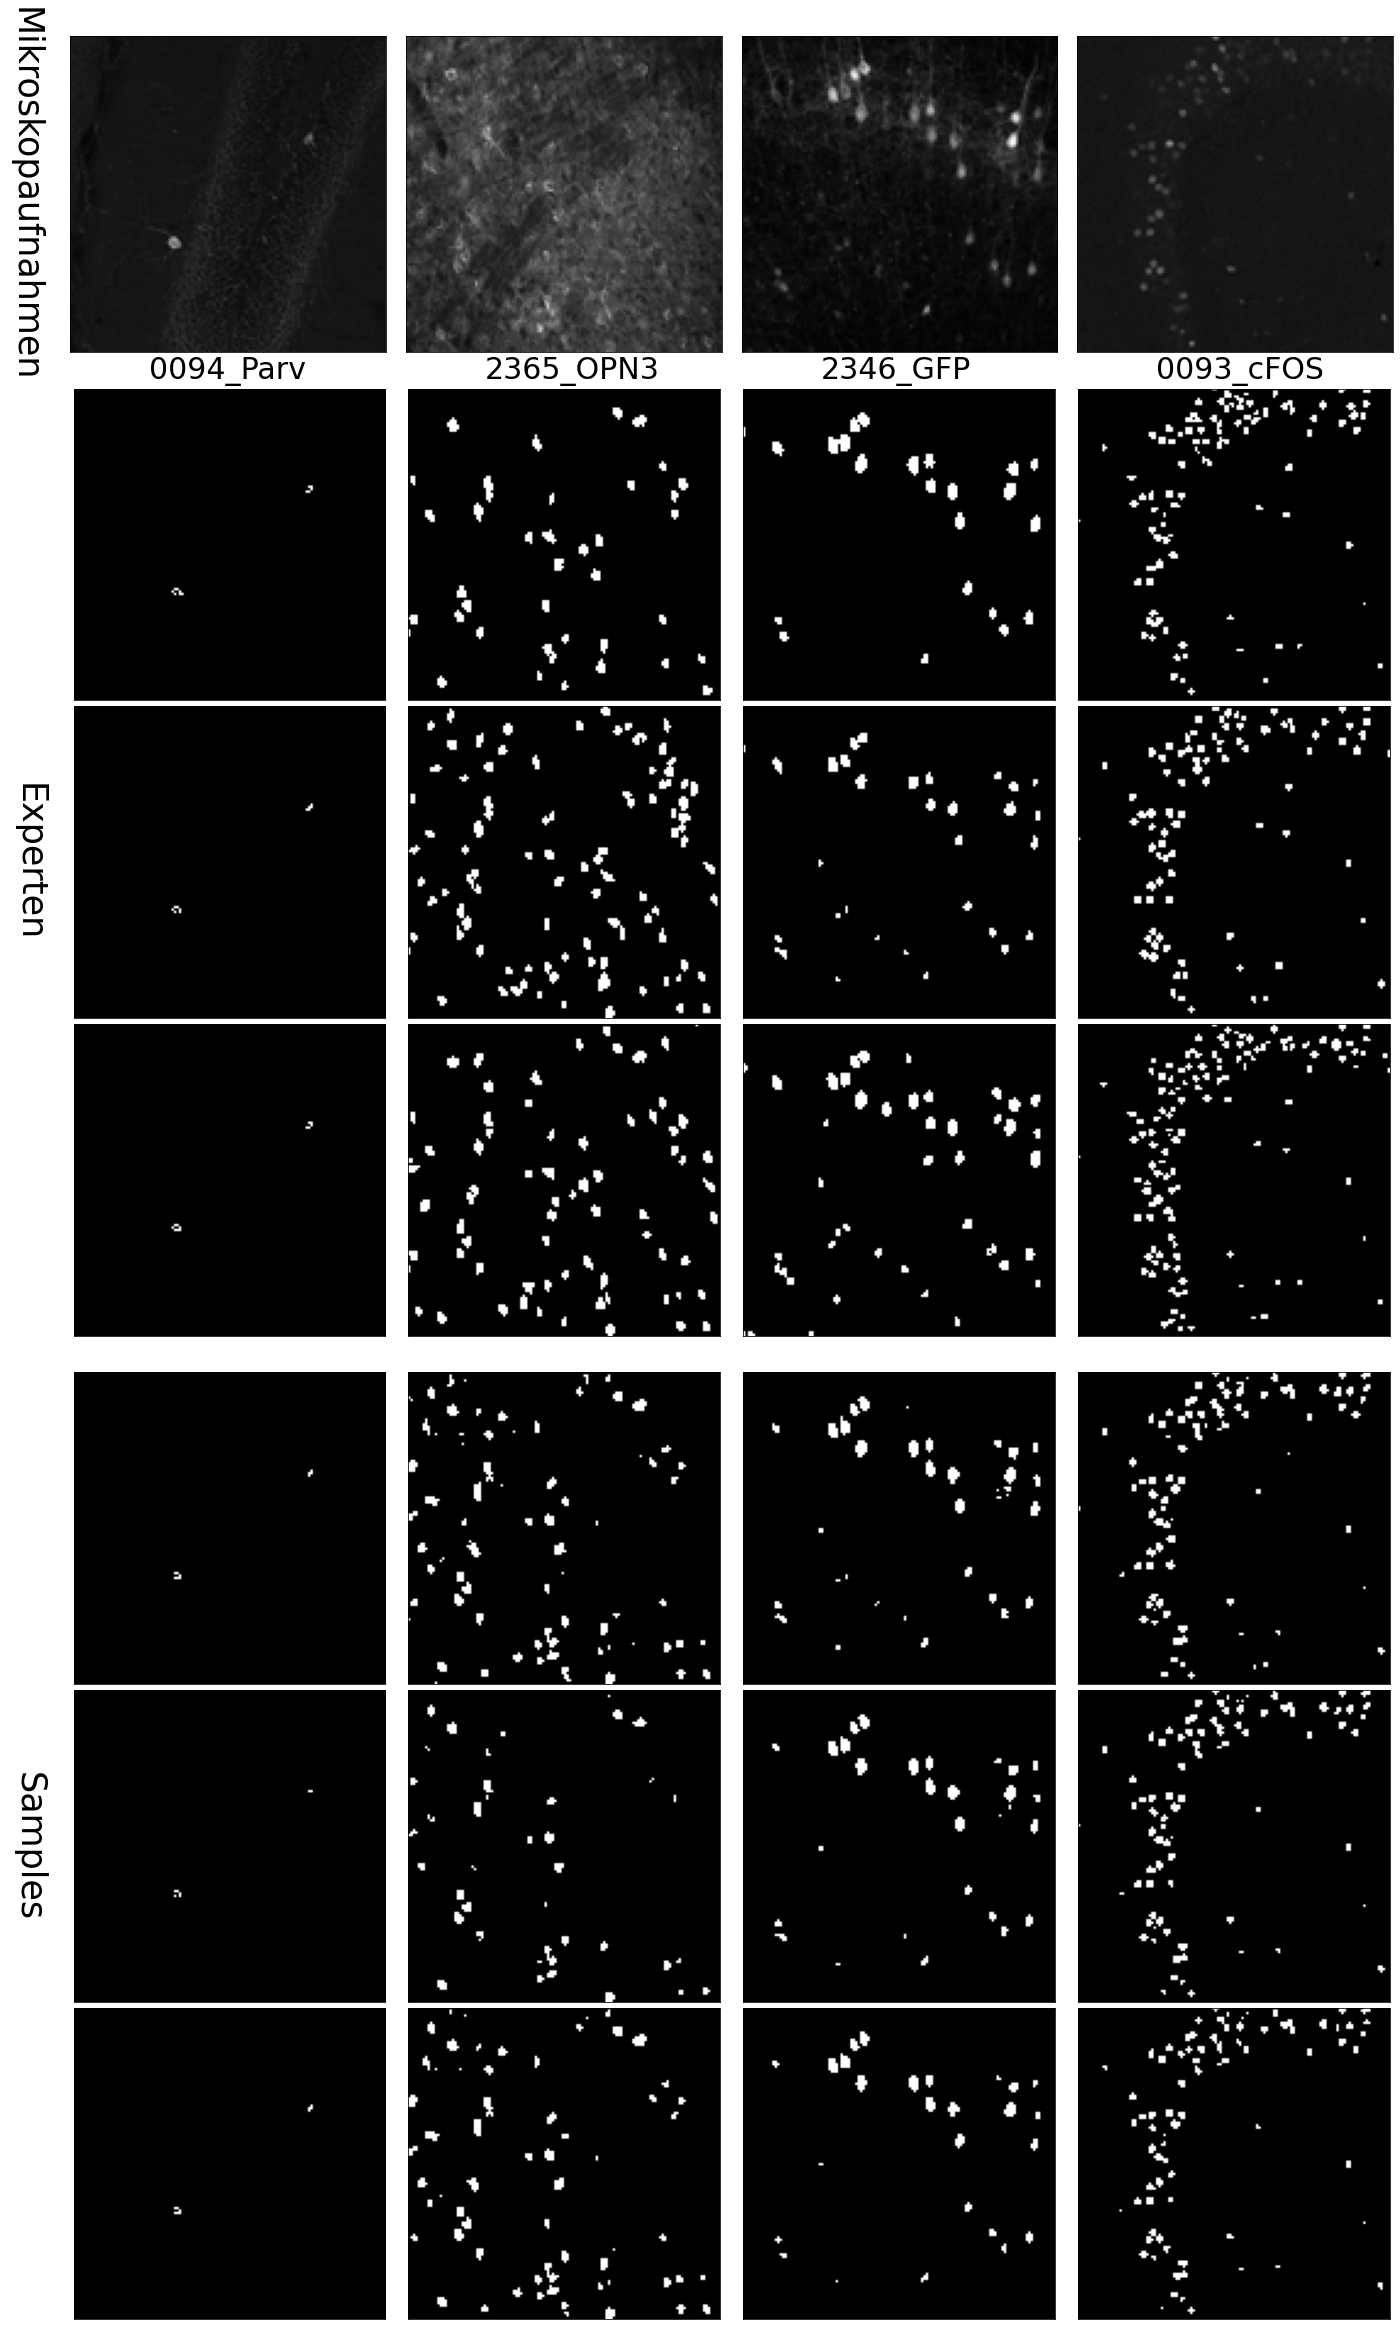

In [17]:
make_ds_plot(batch['data'], batch['seg'], batch['sample'], batch['id'], fs=6)

## Einzelne Grader-Sample-Paarungen

In [407]:
def plot_mic(index):
    fig=plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title('Mikroskop-Scan').set_fontsize(15)
    plt.imshow(batch['data'][index], cmap='gray')
    img_name = batch['id'][index]
    plt.savefig(os.path.join(cf.out_dir, 'plots/{}_img.png'.format(img_name)))

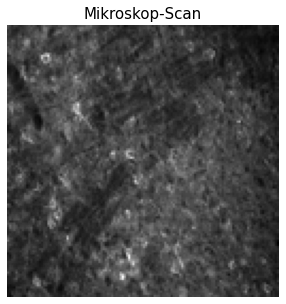

In [408]:
plot_mic(1)

In [411]:
def plot_experts(index):
    rows = 1
    cols = 3
    axes=[]
    fig=plt.figure(figsize=(10,5))
    img =  batch['seg']

    for a in range(rows*cols):
        b = img[index,...,a]
        axes.append(fig.add_subplot(rows, cols, a+1))
        if a == 1:
            subplot_title=("Experten")
            axes[-1].set_title(subplot_title).set_fontsize(15)
        axes[-1].get_xaxis().set_visible(False)
        axes[-1].get_yaxis().set_visible(False)
        plt.imshow(b, cmap='gray')
    img_name = batch['id'][index]
    plt.savefig(os.path.join(cf.out_dir, 'plots/{}_seg.png'.format(img_name)))
    fig.tight_layout()    
    plt.show()

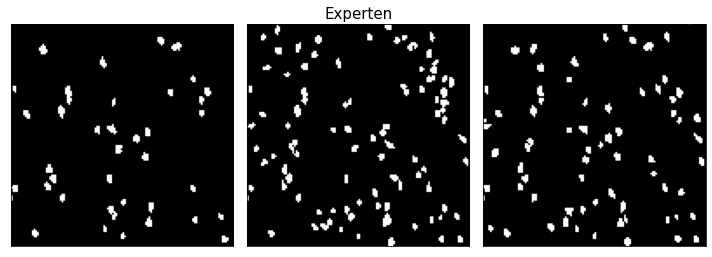

In [412]:
plot_experts(1)

In [413]:
def plot_samples(index):
    rows = 1
    cols = 3
    axes=[]
    fig=plt.figure(figsize=(10,5))
    img =  batch['sample']

    for a in range(rows*cols):
        b = img[index,...,a]
        axes.append(fig.add_subplot(rows, cols, a+1))
        if a == 1:
            subplot_title=("Samples")
            axes[-1].set_title(subplot_title).set_fontsize(15)
        axes[-1].get_xaxis().set_visible(False)
        axes[-1].get_yaxis().set_visible(False)
        plt.imshow(b, cmap='gray')
    img_name = batch['id'][index]
    plt.savefig(os.path.join(cf.out_dir, 'plots/{}_samples.png'.format(img_name)))
    fig.tight_layout()    
    plt.show()

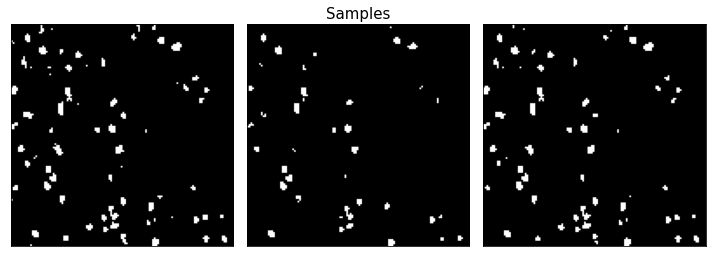

In [414]:
plot_samples(1)

## Plots Standardabweichungen

In [380]:
def generate_std_samples(cf, batch_size=8):

    """Assembles a batch of the first image for each specified patient.
    A tuple holding the batched image of shape (b, 1, 128, 128) and the batched
    segmentations of shape (b, 4, 128, 128).
    """
    img, seg, ids, samples, avg_masks, avg_experts = [], [], [], [], [], []
    patient_dirs = glob(os.path.join(cf.out_dir, 'images', '*'))
    
    # Select one image per subdataset
    parvs = [s for s in patient_dirs if 'Parv' in s]
    opns = [s for s in patient_dirs if 'OPN3' in s]
    gfps = [s for s in patient_dirs if 'GFP' in s]
    cfoss = [s for s in patient_dirs if 'cFOS' in s]
    
    parv = list(np.random.choice(parvs, 1, replace=False))
    opn = list(np.random.choice(opns, 1, replace=False))
    gfp = list(np.random.choice(gfps, 1, replace=False))
    cfos = list(np.random.choice(cfoss, 1, replace=False))
    
    img_ixs = parv + opn + gfp + cfos

    for i in range(4):
        # get the first image for the patient
        img_path = img_ixs[i]
        pth_split = img_path.rsplit('/', 1)[-1][:-4]
        ids.append(pth_split)

        image = np.load(img_path)
        #image = image[np.newaxis, np.newaxis, ...]
        img.append(image)

        # get the corresponding ground truth label
        gt_base_path = img_path.replace('images', 'gt')
        # Für alle 4 Expertenmasken zu bestimmtem Bild:
        labels = []
        for l in range(cf.num_graders):
            gt_path = gt_base_path.replace('.npy', '_l{}.npy'.format(l))
            label = np.load(gt_path)
            labels.append(label)
        labels = np.concatenate(labels, axis=1)
        avg_expert = np.sum(labels, axis = 1)
        avg_experts.append(avg_expert)
        seg.append(labels)
        
        # Samples
        sample_base_path = img_path.replace('images/', '')
        sample_list = []
        for i in range(cf.num_graders):
            new_path = sample_base_path.replace('.npy', '_sample{}.npy'.format(i))
            sample = np.load(new_path)
            sample_list.append(sample)
        array = np.concatenate(sample_list, axis=1)
        avg_mask = np.sum(array, axis = 1)
        avg_masks.append(avg_mask)
        samples.append(array)
    
    # Concat and rearrange np arrays for BHWC format
    img_batch = np.concatenate(img, axis=0)
    img_batch = np.transpose(img_batch, (0, 2, 3, 1))
    seg_batch = np.concatenate(seg, axis=0)
    seg_batch = np.transpose(seg_batch, (0, 2, 3, 1))
    sample_batch = np.concatenate(samples, axis=0)
    sample_batch = np.transpose(sample_batch, (0, 2, 3, 1))
    avg_mask_batch = np.concatenate(avg_masks, axis=0)
   # avg_mask_batch = np.transpose(avg_mask_batch, (0, 2, 3, 1))
    avg_expert_batch = np.concatenate(avg_experts, axis=0)
    #avg_expert_batch = np.transpose(avg_expert_batch, (0, 2, 3, 1))

    batch = {'data': np.array(img_batch).astype('float32'), 'seg': np.array(seg_batch).astype('uint8'),
             'sample': np.array(sample_batch).astype('uint8'), 'avg_masks': np.array(avg_mask_batch).astype('uint8'),
             'avg_experts': np.array(avg_expert_batch).astype('uint8'), 'id': ids}

    return batch

In [381]:
batch = generate_std_samples(cf)

In [382]:
def make_std_plot(img, seg, samples, avg_experts, avg_masks, ids, fs=6):
  """
  Make a grid plot of a batch of images, set of ground truth segmentations and
  corresponding reconstructions and samples. Each example is displayed in a 
  column of the plot.
  :img: Batch of images, array of shape (b, h, w, 1).
  :seg: Batch of segmentations, array of shape  (b, h, w, num_graders).
  :samples: Batch of samples, array of shape (b, h, w, num_classes,
   num_samples).
  :fs: Font size, integer.
  """
  num_samples = samples.shape[-1]
  num_graders = seg.shape[-1]
  bs = img.shape[0]
  num_rows = 5

  f = plt.figure(figsize=(bs * fs, num_rows * fs))
  outer = gridspec.GridSpec(5, 1, wspace=0.1, hspace=0.1,
                            height_ratios=[1, 1, 1, 1, 1])

  img_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[0], wspace=0.0, hspace=0.0)
  exp_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[1], wspace=0.0, hspace=0.0)
  avg_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[2], wspace=0.0, hspace=0.0)
  grader_std_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[3], wspace=0.0, hspace=0.0)
  sample_std_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[4], wspace=0.0, hspace=0.0)
  for j in range(bs):
      # image
      ax = plt.subplot(img_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(np.concatenate([img[j] for _ in range(3)], axis=-1))
      ax.annotate(ids[j], (0.25, -0.07), xycoords='axes fraction',
              va='center').set_fontsize(25)
      if j == 0:
        ax.annotate('Mikroskopaufnahmen', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        
      # avg experts
      ax = plt.subplot(exp_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(avg_experts[j], cmap='gray')
      if j == 0:
        ax.annotate('Durchschnittsmaske', (-0.35, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        ax.annotate('Experten', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        
      # avg samples
      ax = plt.subplot(avg_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(avg_masks[j], cmap='gray')
      if j == 0:
        ax.annotate('Durchschnittsmaske', (-0.35, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        ax.annotate('Samples', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)

        
      # grader standard deviation
      ax = plt.subplot(grader_std_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      std = np.std(seg[j], axis=-1)
      plt.imshow(std, cmap=plt.get_cmap('jet'))
      if j == 0:
        ax.annotate('Experten', (-0.35, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        ax.annotate('Std. Abw.', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)

      # sample standard deviation
      ax = plt.subplot(sample_std_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #samples_argmax = np.argmax(samples[j], axis=-2)
      std = np.std(samples[j], axis=-1)
      plt.imshow(std, cmap=plt.get_cmap('jet'))
      if j == 0:
        ax.annotate('Samples', (-0.35, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        ax.annotate('Std. Abw.', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90).set_fontsize(25)
        
      plt.savefig(os.path.join(cf.out_dir, 'plots/summary_std_dev.png'))

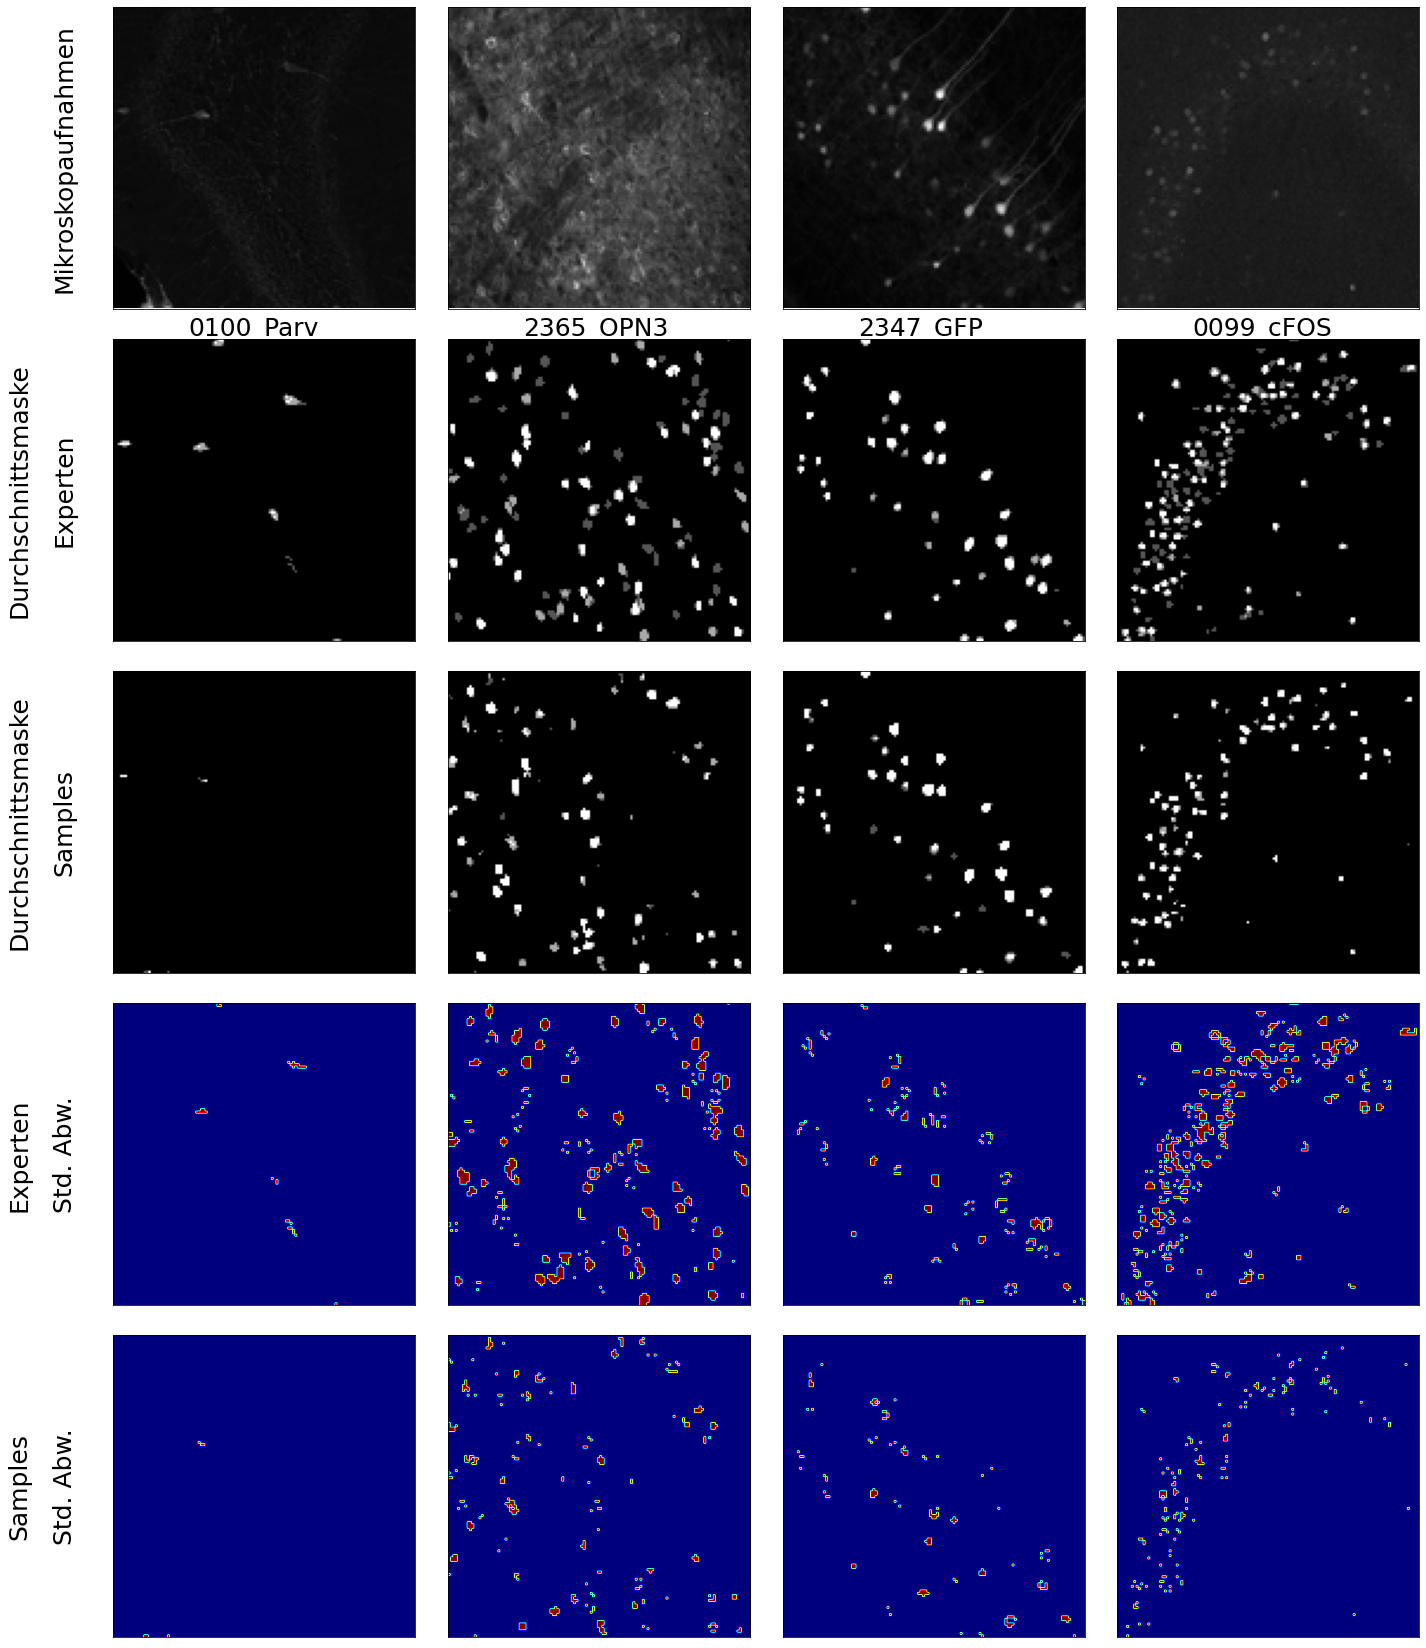

In [383]:
make_std_plot(batch['data'], batch['seg'], batch['sample'], batch['avg_experts'], batch['avg_masks'], batch['id'], fs=6)

## Einzelne Std. Abw.-Paarungen

In [384]:
def plot_mic(index):
    fig=plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title('Mikroskop-Scan').set_fontsize(15)
    plt.imshow(batch['data'][index], cmap='gray')
    img_name = batch['id'][index]
    plt.savefig(os.path.join(cf.out_dir, 'plots/{}_img.png'.format(img_name)))

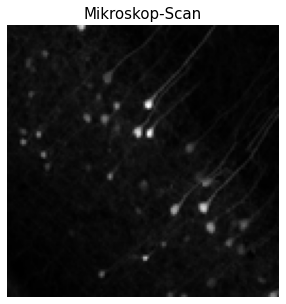

In [385]:
plot_mic(2)

In [386]:
def plot_expert_std(index):
    fig=plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title('Std. Abw. Experten').set_fontsize(15)
    std = np.std(batch['seg'][index], axis=-1)
    plt.imshow(std, cmap=plt.get_cmap('jet'))
    img_name = batch['id'][index]
    plt.savefig(os.path.join(cf.out_dir, 'plots/{}_std_exp.png'.format(img_name)))

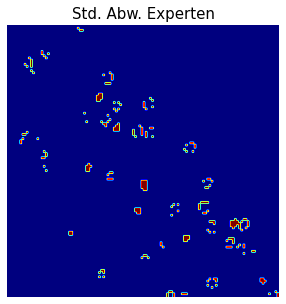

In [387]:
plot_expert_std(2)

In [388]:
def plot_sample_std(index):
    fig=plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title('Std. Abw. Samples').set_fontsize(15)
    std = np.std(batch['sample'][index], axis=-1)
    plt.imshow(std, cmap=plt.get_cmap('jet'))
    img_name = batch['id'][index]
    plt.savefig(os.path.join(cf.out_dir, 'plots/{}_std_smpl.png'.format(img_name)))

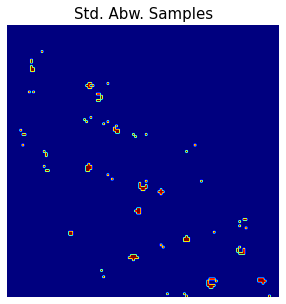

In [389]:
plot_sample_std(2)